# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-coreset'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def coreset_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = [0]  # Start with an arbitrary first sample (e.g., index 0)
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices].min(axis=0)
        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(selected_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4338, Accuracy: 0.7961, F1 Micro: 0.327, F1 Macro: 0.1679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.8222, F1 Micro: 0.3282, F1 Macro: 0.2016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.8208, F1 Micro: 0.3666, F1 Macro: 0.2241
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.8459, F1 Micro: 0.5582, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.8683, F1 Micro: 0.6486, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.8708, F1 Micro: 0.6661, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.8716, F1 Micro: 0.6754, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.8722, F1 Micro: 0.6873, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3719, Accuracy: 0.8213, F1 Micro: 0.3544, F1 Macro: 0.2021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.8369, F1 Micro: 0.4429, F1 Macro: 0.3473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1516, Accuracy: 0.8675, F1 Micro: 0.6756, F1 Macro: 0.6398
Epoch 4/10, Train Loss: 0.1142, Accuracy: 0.8669, F1 Micro: 0.6041, F1 Macro: 0.5582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.088, Accuracy: 0.8794, F1 Micro: 0.6963, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0694, Accuracy: 0.8805, F1 Micro: 0.7229, F1 Macro: 0.7146
Epoch 7/10, Train Loss: 0.0533, Accuracy: 0.8836, F1 Micro: 0.7138, F1 Macro: 0.7007
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.8848, F1 Micro: 0.7102, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.8833, F1 Micro: 0.7283, F1 Macro: 0.7173
Epoch 10/10, Train Loss: 0.0324, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.8253, F1 Micro: 0.3575, F1 Macro: 0.2087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.204, Accuracy: 0.8539, F1 Micro: 0.5649, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1394, Accuracy: 0.8758, F1 Micro: 0.6604, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1023, Accuracy: 0.8802, F1 Micro: 0.7228, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.074, Accuracy: 0.8828, F1 Micro: 0.7249, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0576, Accuracy: 0.8866, F1 Micro: 0.7313, F1 Macro: 0.711
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.8869, F1 Micro: 0.7266, F1 Macro: 0.704
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.8839, F1 Micro: 0.7303, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.8845, F1 Micro: 0.7314, F1 Macro: 0.7282
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.334, Accuracy: 0.8344, F1 Micro: 0.3991, F1 Macro: 0.2501
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1719, Accuracy: 0.8737, F1 Micro: 0.688, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1217, Accuracy: 0.8839, F1 Micro: 0.7048, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.088, Accuracy: 0.8833, F1 Micro: 0.731, F1 Macro: 0.7148
Epoch 5/10, Train Loss: 0.0678, Accuracy: 0.8844, F1 Micro: 0.7289, F1 Macro: 0.7164
Epoch 6/10, Train Loss: 0.0502, Accuracy: 0.8875, F1 Micro: 0.7205, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0386, Accuracy: 0.8884, F1 Micro: 0.7363, F1 Macro: 0.7248
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.8877, F1 Micro: 0.7348, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.8875, F1 Micro: 0.7389, F1 Macro: 0.7327
Epoch 10/10, Train Loss: 0.0246, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3341, Accuracy: 0.8358, F1 Micro: 0.4039, F1 Macro: 0.2612
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1735, Accuracy: 0.875, F1 Micro: 0.6531, F1 Macro: 0.5498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1235, Accuracy: 0.8867, F1 Micro: 0.7242, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0942, Accuracy: 0.8878, F1 Micro: 0.7327, F1 Macro: 0.7137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0717, Accuracy: 0.8895, F1 Micro: 0.7436, F1 Macro: 0.7394
Epoch 6/10, Train Loss: 0.0504, Accuracy: 0.8911, F1 Micro: 0.7361, F1 Macro: 0.7317
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.8864, F1 Micro: 0.7338, F1 Macro: 0.7218
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.8902, F1 Micro: 0.7272, F1 Macro: 0.7126
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.8913, F1 Micro: 0.7436, F1 Macro: 0.7373
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0254, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.8367, F1 Micro: 0.4052, F1 Macro: 0.2646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.176, Accuracy: 0.8791, F1 Micro: 0.6764, F1 Macro: 0.5861
Epoch 3/10, Train Loss: 0.1284, Accuracy: 0.8798, F1 Micro: 0.6695, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1034, Accuracy: 0.8909, F1 Micro: 0.7305, F1 Macro: 0.7184
Epoch 5/10, Train Loss: 0.0758, Accuracy: 0.8877, F1 Micro: 0.7257, F1 Macro: 0.7068
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0566, Accuracy: 0.8934, F1 Micro: 0.7516, F1 Macro: 0.7463
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.8919, F1 Micro: 0.7286, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.8927, F1 Micro: 0.757, F1 Macro: 0.7574
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.8906, F1 Micro: 0.7396, F1 Macro: 0.7424
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.8902, F1 Micro: 0.7481, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3266, Accuracy: 0.8511, F1 Micro: 0.515, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.8827, F1 Micro: 0.7095, F1 Macro: 0.6451
Epoch 3/10, Train Loss: 0.1348, Accuracy: 0.8858, F1 Micro: 0.7077, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0969, Accuracy: 0.888, F1 Micro: 0.7156, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0779, Accuracy: 0.8945, F1 Micro: 0.758, F1 Macro: 0.7491
Epoch 6/10, Train Loss: 0.0591, Accuracy: 0.8802, F1 Micro: 0.7488, F1 Macro: 0.7514
Epoch 7/10, Train Loss: 0.0451, Accuracy: 0.8941, F1 Micro: 0.7428, F1 Macro: 0.7372
Epoch 8/10, Train Loss: 0.041, Accuracy: 0.8923, F1 Micro: 0.7551, F1 Macro: 0.7534
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.8886, F1 Micro: 0.7562, F1 Macro: 0.7535
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.8867, F1 Micro: 0.7547, F1 Macro: 0.757

 Iteration 3432: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3317, Accuracy: 0.8519, F1 Micro: 0.5425, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1842, Accuracy: 0.883, F1 Micro: 0.7019, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1419, Accuracy: 0.887, F1 Micro: 0.754, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.106, Accuracy: 0.8961, F1 Micro: 0.7612, F1 Macro: 0.7583
Epoch 5/10, Train Loss: 0.0844, Accuracy: 0.88, F1 Micro: 0.7562, F1 Macro: 0.7622
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.8916, F1 Micro: 0.748, F1 Macro: 0.7423
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.8931, F1 Micro: 0.7487, F1 Macro: 0.7419
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.8936, F1 Micro: 0.7488, F1 Macro: 0.7413
Epoch 9/10, Train Loss: 0.0259, Accuracy: 0.8878, F1 Micro: 0.7521, F1 Macro: 0.7482
Epoch 10/10, Train Loss: 0.024, Accuracy: 0.8953, F1 Micro: 0.7509, F1 Macro: 0.7367

 Iteration 3711: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3198, Accuracy: 0.8552, F1 Micro: 0.5239, F1 Macro: 0.4493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.8867, F1 Micro: 0.7154, F1 Macro: 0.6812
Epoch 3/10, Train Loss: 0.1357, Accuracy: 0.8908, F1 Micro: 0.7094, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.104, Accuracy: 0.8938, F1 Micro: 0.7557, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0821, Accuracy: 0.8964, F1 Micro: 0.7616, F1 Macro: 0.7486
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.8938, F1 Micro: 0.7414, F1 Macro: 0.7234
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.8916, F1 Micro: 0.7397, F1 Macro: 0.7311
Epoch 8/10, Train Loss: 0.0308, Accuracy: 0.8923, F1 Micro: 0.7552, F1 Macro: 0.7536
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.8909, F1 Micro: 0.7556, F1 Macro: 0.7546
Epoch 10/10, Train Loss: 0.0196, Accuracy: 0.8936, F1 Micro: 0.7598, F1 Macro: 0.7519

 Iteration 3886: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3317, Accuracy: 0.8609, F1 Micro: 0.5921, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1984, Accuracy: 0.8836, F1 Micro: 0.6745, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1493, Accuracy: 0.8941, F1 Micro: 0.7384, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.117, Accuracy: 0.8877, F1 Micro: 0.752, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0923, Accuracy: 0.8967, F1 Micro: 0.7571, F1 Macro: 0.7507
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.8955, F1 Micro: 0.7478, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.8941, F1 Micro: 0.7659, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.0368, Accuracy: 0.8914, F1 Micro: 0.7576, F1 Macro: 0.7503
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.893, F1 Micro: 0.756, F1 Macro: 0.7508
Epoch 10/10, Train Loss: 0.0228, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3316, Accuracy: 0.8664, F1 Micro: 0.6129, F1 Macro: 0.5344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.193, Accuracy: 0.8903, F1 Micro: 0.731, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.8942, F1 Micro: 0.7389, F1 Macro: 0.7292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.8989, F1 Micro: 0.7528, F1 Macro: 0.7416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.8966, F1 Micro: 0.7671, F1 Macro: 0.7598
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.8905, F1 Micro: 0.7603, F1 Macro: 0.759
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.8973, F1 Micro: 0.7525, F1 Macro: 0.7445
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.8898, F1 Micro: 0.76, F1 Macro: 0.7571
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.8947, F1 Micro: 0.762, F1 Macro: 0.7559
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0.8959, F1 Micro: 0.7524, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3407, Accuracy: 0.8737, F1 Micro: 0.6591, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2041, Accuracy: 0.8903, F1 Micro: 0.7212, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1576, Accuracy: 0.9006, F1 Micro: 0.7704, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.9022, F1 Micro: 0.7794, F1 Macro: 0.7786
Epoch 5/10, Train Loss: 0.0953, Accuracy: 0.8988, F1 Micro: 0.7545, F1 Macro: 0.7479
Epoch 6/10, Train Loss: 0.065, Accuracy: 0.8922, F1 Micro: 0.767, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.9016, F1 Micro: 0.7702, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.8889, F1 Micro: 0.7579, F1 Macro: 0.7593
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9023, F1 Micro: 0.7642, F1 Macro: 0.7633
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.8953, F1 Micro: 0.7654, F1 Macro: 0.7581

 Iteration 4530: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.343, Accuracy: 0.8763, F1 Micro: 0.6722, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2001, Accuracy: 0.8919, F1 Micro: 0.7336, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.8963, F1 Micro: 0.7613, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1236, Accuracy: 0.9017, F1 Micro: 0.7631, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0939, Accuracy: 0.8978, F1 Micro: 0.7748, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.068, Accuracy: 0.9038, F1 Micro: 0.7833, F1 Macro: 0.7823
Epoch 7/10, Train Loss: 0.0501, Accuracy: 0.9017, F1 Micro: 0.7717, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.8948, F1 Micro: 0.7694, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.8981, F1 Micro: 0.7433, F1 Macro: 0.7264
Epoch 10/10, Train Loss: 0.0298, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3389, Accuracy: 0.8719, F1 Micro: 0.6346, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2089, Accuracy: 0.8972, F1 Micro: 0.7592, F1 Macro: 0.749
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9016, F1 Micro: 0.7568, F1 Macro: 0.7441
Epoch 4/10, Train Loss: 0.1293, Accuracy: 0.9016, F1 Micro: 0.752, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.098, Accuracy: 0.9005, F1 Micro: 0.7716, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.9048, F1 Micro: 0.7783, F1 Macro: 0.7737
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.9036, F1 Micro: 0.7711, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0379, Accuracy: 0.8977, F1 Micro: 0.7807, F1 Macro: 0.7823
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.8966, F1 Micro: 0.7724, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0254, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3508, Accuracy: 0.87, F1 Micro: 0.6201, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.8948, F1 Micro: 0.7538, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9027, F1 Micro: 0.7737, F1 Macro: 0.7692
Epoch 4/10, Train Loss: 0.1345, Accuracy: 0.8942, F1 Micro: 0.7703, F1 Macro: 0.7682
Epoch 5/10, Train Loss: 0.0916, Accuracy: 0.8997, F1 Micro: 0.771, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9009, F1 Micro: 0.7779, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.8992, F1 Micro: 0.7767, F1 Macro: 0.7776
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9016, F1 Micro: 0.7612, F1 Macro: 0.7542
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.8991, F1 Micro: 0.7691, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9033, F1 Micro: 0.7748, F1 Macro: 0.776

 Iteration 5063: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3514, Accuracy: 0.8839, F1 Micro: 0.722, F1 Macro: 0.6971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2175, Accuracy: 0.9008, F1 Micro: 0.7623, F1 Macro: 0.7533
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9009, F1 Micro: 0.755, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9045, F1 Micro: 0.7781, F1 Macro: 0.7724
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.8991, F1 Micro: 0.7557, F1 Macro: 0.7463
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9006, F1 Micro: 0.7573, F1 Macro: 0.748
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.9011, F1 Micro: 0.7601, F1 Macro: 0.7533
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.8989, F1 Micro: 0.752, F1 Macro: 0.7457
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.8981, F1 Micro: 0.7699, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8938, F1 Micro: 0.7652, F1 Macro: 0.765

 Iteration 5263: Accuracy: 0.9045, F1 Micro: 0.7781, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3541, Accuracy: 0.8797, F1 Micro: 0.7125, F1 Macro: 0.6827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.8969, F1 Micro: 0.7487, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9042, F1 Micro: 0.7661, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.8989, F1 Micro: 0.7782, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9047, F1 Micro: 0.7796, F1 Macro: 0.7733
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.8955, F1 Micro: 0.7731, F1 Macro: 0.7713
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9028, F1 Micro: 0.7649, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9061, F1 Micro: 0.7837, F1 Macro: 0.7833
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9036, F1 Micro: 0.7789, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0287, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.8831, F1 Micro: 0.711, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.8984, F1 Micro: 0.7427, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9077, F1 Micro: 0.7825, F1 Macro: 0.7779
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9077, F1 Micro: 0.7717, F1 Macro: 0.758
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9072, F1 Micro: 0.779, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9036, F1 Micro: 0.7797, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9042, F1 Micro: 0.7724, F1 Macro: 0.7707
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9033, F1 Micro: 0.7686, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9066, F1 Micro: 0.7858, F1 Macro: 0.7852
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9003, F1 Micro: 0.7769, F1 Macro: 0.7733

 Iteration 5641: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.8856, F1 Micro: 0.7265, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.8986, F1 Micro: 0.7365, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9042, F1 Micro: 0.764, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9027, F1 Micro: 0.7768, F1 Macro: 0.7682
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9033, F1 Micro: 0.7756, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9062, F1 Micro: 0.7805, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9019, F1 Micro: 0.7782, F1 Macro: 0.7777
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.903, F1 Micro: 0.7789, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9077, F1 Micro: 0.7845, F1 Macro: 0.7815
Epoch 10/10, Train Loss: 0.0286, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3661, Accuracy: 0.8853, F1 Micro: 0.7113, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.8998, F1 Micro: 0.7611, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.903, F1 Micro: 0.7726, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9066, F1 Micro: 0.7885, F1 Macro: 0.788
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9, F1 Micro: 0.7764, F1 Macro: 0.7744
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9033, F1 Micro: 0.7554, F1 Macro: 0.7487
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.902, F1 Micro: 0.7758, F1 Macro: 0.7753
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.903, F1 Micro: 0.7714, F1 Macro: 0.7682
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9047, F1 Micro: 0.7666, F1 Macro: 0.7529
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.903, F1 Micro: 0.7767, F1 Macro: 0.7722

 Iteration 6041: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3722, Accuracy: 0.8867, F1 Micro: 0.704, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.8989, F1 Micro: 0.7643, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9041, F1 Micro: 0.7871, F1 Macro: 0.7854
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9013, F1 Micro: 0.7727, F1 Macro: 0.7722
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9042, F1 Micro: 0.7629, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9078, F1 Micro: 0.7888, F1 Macro: 0.7859
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9038, F1 Micro: 0.7757, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9041, F1 Micro: 0.7769, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9055, F1 Micro: 0.777, F1 Macro: 0.7718

 Iteration 6218: Ac

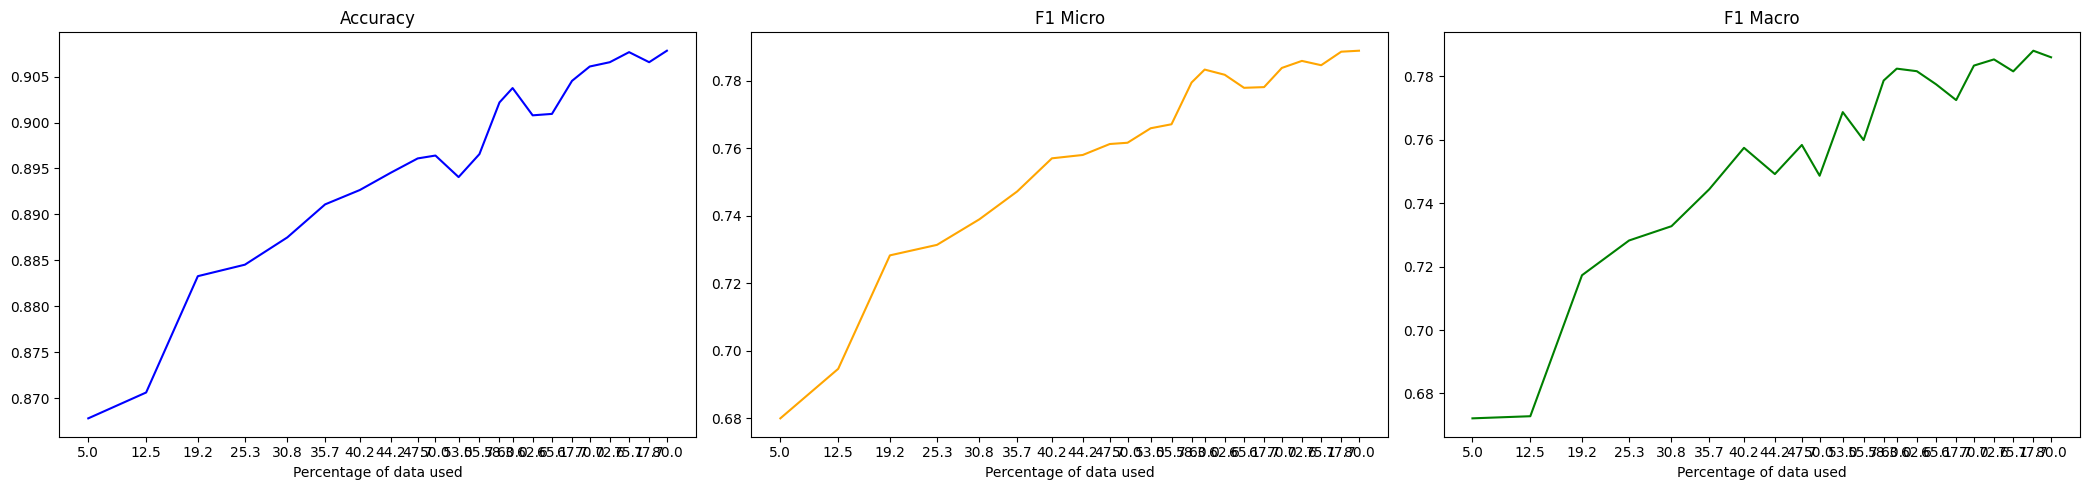

In [19]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4973, Accuracy: 0.7958, F1 Micro: 0.0815, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4357, Accuracy: 0.8263, F1 Micro: 0.3178, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8441, F1 Micro: 0.4791, F1 Macro: 0.4013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.848, F1 Micro: 0.5003, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3181, Accuracy: 0.8561, F1 Micro: 0.569, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.28, Accuracy: 0.8608, F1 Micro: 0.6101, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2362, Accuracy: 0.8725, F1 Micro: 0.6686, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1874, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4179, Accuracy: 0.7795, F1 Micro: 0.312, F1 Macro: 0.1515
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.8273, F1 Micro: 0.4905, F1 Macro: 0.3907
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.8342, F1 Micro: 0.4002, F1 Macro: 0.3349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.8553, F1 Micro: 0.6012, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.8695, F1 Micro: 0.6588, F1 Macro: 0.648
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.8531, F1 Micro: 0.5323, F1 Macro: 0.4478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.8806, F1 Micro: 0.7077, F1 Macro: 0.6991
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.8744, F1 Micro: 0.6724, F1 Macro: 0.6527
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.8745, F1 Micro: 0.6896, F1 Macro: 0.6678
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.8755, F1 Micro: 0.6919, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3672, Accuracy: 0.8105, F1 Micro: 0.3692, F1 Macro: 0.216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2065, Accuracy: 0.8364, F1 Micro: 0.539, F1 Macro: 0.3603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1477, Accuracy: 0.8623, F1 Micro: 0.6107, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1093, Accuracy: 0.8773, F1 Micro: 0.6916, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.8813, F1 Micro: 0.7121, F1 Macro: 0.6949
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.8792, F1 Micro: 0.7055, F1 Macro: 0.6764
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.8789, F1 Micro: 0.6988, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.8839, F1 Micro: 0.7197, F1 Macro: 0.7001
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.8778, F1 Micro: 0.6957, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3436, Accuracy: 0.8313, F1 Micro: 0.3807, F1 Macro: 0.2476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1885, Accuracy: 0.8544, F1 Micro: 0.5335, F1 Macro: 0.4446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.8786, F1 Micro: 0.7104, F1 Macro: 0.6695
Epoch 4/10, Train Loss: 0.1075, Accuracy: 0.8808, F1 Micro: 0.6846, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0806, Accuracy: 0.8798, F1 Micro: 0.7151, F1 Macro: 0.6841
Epoch 6/10, Train Loss: 0.0628, Accuracy: 0.885, F1 Micro: 0.7077, F1 Macro: 0.6937
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.8827, F1 Micro: 0.7054, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.8825, F1 Micro: 0.7245, F1 Macro: 0.7212
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.8831, F1 Micro: 0.724, F1 Macro: 0.7166
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.8827, F1 Micro: 0.7083, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3398, Accuracy: 0.8389, F1 Micro: 0.4132, F1 Macro: 0.3267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.8723, F1 Micro: 0.6764, F1 Macro: 0.5702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1138, Accuracy: 0.8822, F1 Micro: 0.7224, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0976, Accuracy: 0.875, F1 Micro: 0.7306, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0728, Accuracy: 0.8828, F1 Micro: 0.731, F1 Macro: 0.7263
Epoch 6/10, Train Loss: 0.0552, Accuracy: 0.8856, F1 Micro: 0.7095, F1 Macro: 0.6868
Epoch 7/10, Train Loss: 0.0408, Accuracy: 0.8872, F1 Micro: 0.7212, F1 Macro: 0.7134
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.8866, F1 Micro: 0.7426, F1 Macro: 0.7388
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.8877, F1 Micro: 0.7371, F1 Macro: 0.7276
Epoch 10/10, Train Loss: 0.0228, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3249, Accuracy: 0.8466, F1 Micro: 0.5124, F1 Macro: 0.4168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1726, Accuracy: 0.8653, F1 Micro: 0.5895, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1373, Accuracy: 0.8777, F1 Micro: 0.6471, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0994, Accuracy: 0.8844, F1 Micro: 0.7233, F1 Macro: 0.703
Epoch 5/10, Train Loss: 0.0818, Accuracy: 0.8839, F1 Micro: 0.7069, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.8831, F1 Micro: 0.726, F1 Macro: 0.7127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0395, Accuracy: 0.8884, F1 Micro: 0.733, F1 Macro: 0.7285
Epoch 8/10, Train Loss: 0.0371, Accuracy: 0.8864, F1 Micro: 0.7121, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.89, F1 Micro: 0.7361, F1 Macro: 0.7245
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3301, Accuracy: 0.847, F1 Micro: 0.4806, F1 Macro: 0.3972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.185, Accuracy: 0.8781, F1 Micro: 0.6803, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.133, Accuracy: 0.8828, F1 Micro: 0.6903, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1101, Accuracy: 0.8942, F1 Micro: 0.7525, F1 Macro: 0.7417
Epoch 5/10, Train Loss: 0.0864, Accuracy: 0.8831, F1 Micro: 0.6631, F1 Macro: 0.6121
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.8925, F1 Micro: 0.7514, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.8914, F1 Micro: 0.765, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.8903, F1 Micro: 0.7165, F1 Macro: 0.6902
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.8922, F1 Micro: 0.7607, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.0206, Accuracy: 0.8942, F1 Micro: 0.7544, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3164, Accuracy: 0.8547, F1 Micro: 0.5455, F1 Macro: 0.4547
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.8859, F1 Micro: 0.7142, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1346, Accuracy: 0.8891, F1 Micro: 0.7169, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1081, Accuracy: 0.8988, F1 Micro: 0.7666, F1 Macro: 0.7591
Epoch 5/10, Train Loss: 0.0802, Accuracy: 0.8942, F1 Micro: 0.7365, F1 Macro: 0.7215
Epoch 6/10, Train Loss: 0.0629, Accuracy: 0.8961, F1 Micro: 0.7455, F1 Macro: 0.7318
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.8975, F1 Micro: 0.7665, F1 Macro: 0.765
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.8956, F1 Micro: 0.7621, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.8959, F1 Micro: 0.7472, F1 Macro: 0.7405
Epoch 10/10, Train Loss: 0.0199, Accuracy: 0.8922, F1 Micro: 0.764, F1 Macro: 0.7662

 Iteration 3432: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.325, Accuracy: 0.858, F1 Micro: 0.5734, F1 Macro: 0.4876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.8811, F1 Micro: 0.6785, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1359, Accuracy: 0.8933, F1 Micro: 0.7388, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1126, Accuracy: 0.8933, F1 Micro: 0.7621, F1 Macro: 0.7628
Epoch 5/10, Train Loss: 0.0779, Accuracy: 0.8909, F1 Micro: 0.7605, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0659, Accuracy: 0.8988, F1 Micro: 0.765, F1 Macro: 0.758
Epoch 7/10, Train Loss: 0.0438, Accuracy: 0.8963, F1 Micro: 0.7623, F1 Macro: 0.7591
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.8972, F1 Micro: 0.7576, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9008, F1 Micro: 0.7642, F1 Macro: 0.7573
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.8891, F1 Micro: 0.7619, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3259, Accuracy: 0.8595, F1 Micro: 0.5848, F1 Macro: 0.5122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.8866, F1 Micro: 0.7121, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1508, Accuracy: 0.8964, F1 Micro: 0.7534, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1103, Accuracy: 0.8984, F1 Micro: 0.7682, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9003, F1 Micro: 0.77, F1 Macro: 0.7675
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.8895, F1 Micro: 0.7667, F1 Macro: 0.7702
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.8961, F1 Micro: 0.7636, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.8986, F1 Micro: 0.7708, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.8972, F1 Micro: 0.7723, F1 Macro: 0.7722
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3197, Accuracy: 0.8561, F1 Micro: 0.5566, F1 Macro: 0.4646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.8923, F1 Micro: 0.7477, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.8959, F1 Micro: 0.7721, F1 Macro: 0.7734
Epoch 4/10, Train Loss: 0.1183, Accuracy: 0.8966, F1 Micro: 0.7554, F1 Macro: 0.7454
Epoch 5/10, Train Loss: 0.0991, Accuracy: 0.8977, F1 Micro: 0.7454, F1 Macro: 0.7207
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.902, F1 Micro: 0.7713, F1 Macro: 0.7679
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.9028, F1 Micro: 0.7658, F1 Macro: 0.7562
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.8986, F1 Micro: 0.7696, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9003, F1 Micro: 0.7618, F1 Macro: 0.7511
Epoch 10/10, Train Loss: 0.0252, Accuracy: 0.8989, F1 Micro: 0.7719, F1 Macro: 0.7678

 Iteration 4120: Accuracy: 0.8959, F1 Micro: 0.772

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3264, Accuracy: 0.8673, F1 Micro: 0.6129, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1972, Accuracy: 0.8886, F1 Micro: 0.7084, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1532, Accuracy: 0.8997, F1 Micro: 0.7689, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1293, Accuracy: 0.9, F1 Micro: 0.7716, F1 Macro: 0.7675
Epoch 5/10, Train Loss: 0.0894, Accuracy: 0.9017, F1 Micro: 0.7695, F1 Macro: 0.7665
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.9016, F1 Micro: 0.7558, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9011, F1 Micro: 0.7717, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.8966, F1 Micro: 0.7724, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.903, F1 Micro: 0.7699, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0233, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.8612, F1 Micro: 0.5578, F1 Macro: 0.5024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.21, Accuracy: 0.8916, F1 Micro: 0.7399, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9, F1 Micro: 0.7708, F1 Macro: 0.7667
Epoch 4/10, Train Loss: 0.1317, Accuracy: 0.9028, F1 Micro: 0.7534, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1037, Accuracy: 0.8916, F1 Micro: 0.7725, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.8977, F1 Micro: 0.7748, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9011, F1 Micro: 0.7704, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.8995, F1 Micro: 0.7805, F1 Macro: 0.7818
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.8959, F1 Micro: 0.7742, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0248, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.343, Accuracy: 0.8792, F1 Micro: 0.6869, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2104, Accuracy: 0.8916, F1 Micro: 0.7456, F1 Macro: 0.724
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.897, F1 Micro: 0.7451, F1 Macro: 0.7331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9052, F1 Micro: 0.7817, F1 Macro: 0.7742
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.7716
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.9002, F1 Micro: 0.7684, F1 Macro: 0.7645
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9, F1 Micro: 0.7676, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9052, F1 Micro: 0.7741, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.8958, F1 Micro: 0.7735, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9017, F1 Micro: 0.7797, F1 Macro: 0.7791

 Iteration 4663: Accuracy: 0.9052, F1 Micro: 0.7817, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3376, Accuracy: 0.8722, F1 Micro: 0.6374, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2062, Accuracy: 0.8945, F1 Micro: 0.7301, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1636, Accuracy: 0.9022, F1 Micro: 0.7843, F1 Macro: 0.7859
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9025, F1 Micro: 0.7746, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1003, Accuracy: 0.9042, F1 Micro: 0.7621, F1 Macro: 0.7483
Epoch 6/10, Train Loss: 0.0731, Accuracy: 0.9027, F1 Micro: 0.7592, F1 Macro: 0.7488
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9031, F1 Micro: 0.776, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.041, Accuracy: 0.9058, F1 Micro: 0.7813, F1 Macro: 0.7814
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.8998, F1 Micro: 0.7749, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0216, Accuracy: 0.9034, F1 Micro: 0.7733, F1 Macro: 0.7705

 Iteration 4863: Accuracy: 0.9022, F1 Micro: 0.7843,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3381, Accuracy: 0.8827, F1 Micro: 0.7007, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.89, F1 Micro: 0.7363, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.8984, F1 Micro: 0.74, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.902, F1 Micro: 0.7833, F1 Macro: 0.7818
Epoch 5/10, Train Loss: 0.1005, Accuracy: 0.8944, F1 Micro: 0.7775, F1 Macro: 0.7788
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.9048, F1 Micro: 0.7657, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.0542, Accuracy: 0.9027, F1 Micro: 0.7725, F1 Macro: 0.7646
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.9033, F1 Micro: 0.7745, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.903, F1 Micro: 0.782, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.9005, F1 Micro: 0.7669, F1 Macro: 0.7591

 Iteration 5063: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.343, Accuracy: 0.8847, F1 Micro: 0.7097, F1 Macro: 0.6767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.216, Accuracy: 0.8931, F1 Micro: 0.764, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9025, F1 Micro: 0.7744, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9061, F1 Micro: 0.785, F1 Macro: 0.7798
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9014, F1 Micro: 0.7698, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0755, Accuracy: 0.9031, F1 Micro: 0.7864, F1 Macro: 0.7869
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9045, F1 Micro: 0.7811, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9048, F1 Micro: 0.7821, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9033, F1 Micro: 0.7689, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9061, F1 Micro: 0.7798, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.8811, F1 Micro: 0.6672, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.8995, F1 Micro: 0.7614, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.907, F1 Micro: 0.7774, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.9102, F1 Micro: 0.7839, F1 Macro: 0.7773
Epoch 5/10, Train Loss: 0.1048, Accuracy: 0.9069, F1 Micro: 0.7839, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.9078, F1 Micro: 0.7836, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9019, F1 Micro: 0.7836, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9067, F1 Micro: 0.7853, F1 Macro: 0.7846
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9039, F1 Micro: 0.7771, F1 Macro: 0.7695
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9048, F1 Micro: 0.7821, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3493, Accuracy: 0.8917, F1 Micro: 0.7415, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2256, Accuracy: 0.8992, F1 Micro: 0.7661, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9059, F1 Micro: 0.7871, F1 Macro: 0.7825
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9069, F1 Micro: 0.7844, F1 Macro: 0.7825
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9034, F1 Micro: 0.7863, F1 Macro: 0.7853
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.9039, F1 Micro: 0.7769, F1 Macro: 0.7744
Epoch 7/10, Train Loss: 0.0571, Accuracy: 0.9022, F1 Micro: 0.7769, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0427, Accuracy: 0.8998, F1 Micro: 0.7705, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9019, F1 Micro: 0.7786, F1 Macro: 0.7824
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9055, F1 Micro: 0.7825, F1 Macro: 0.7833

 Iteration 5641: Accuracy: 0.9059, F1 Micro: 0.787

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3576, Accuracy: 0.8898, F1 Micro: 0.7232, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9044, F1 Micro: 0.7787, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9083, F1 Micro: 0.7882, F1 Macro: 0.7819
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9028, F1 Micro: 0.7669, F1 Macro: 0.7555
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.8992, F1 Micro: 0.7833, F1 Macro: 0.7847
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9067, F1 Micro: 0.7822, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9045, F1 Micro: 0.7825, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9058, F1 Micro: 0.7819, F1 Macro: 0.7815
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9048, F1 Micro: 0.7843, F1 Macro: 0.7856
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9022, F1 Micro: 0.7823, F1 Macro: 0.7829

 Iteration 5841: Accuracy: 0.9083, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.353, Accuracy: 0.8869, F1 Micro: 0.7111, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2319, Accuracy: 0.9002, F1 Micro: 0.7754, F1 Macro: 0.769
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9047, F1 Micro: 0.7707, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.9047, F1 Micro: 0.7828, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9033, F1 Micro: 0.7669, F1 Macro: 0.7587
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9013, F1 Micro: 0.7712, F1 Macro: 0.7649
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9041, F1 Micro: 0.779, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9023, F1 Micro: 0.778, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9014, F1 Micro: 0.7688, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.903, F1 Micro: 0.7746, F1 Macro: 0.7709

 Iteration 6041: Accuracy: 0.9047, F1 Micro: 0.7828, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3579, Accuracy: 0.8905, F1 Micro: 0.7538, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9013, F1 Micro: 0.7593, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9067, F1 Micro: 0.7894, F1 Macro: 0.7878
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9038, F1 Micro: 0.7839, F1 Macro: 0.7796
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9059, F1 Micro: 0.7782, F1 Macro: 0.7739
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9039, F1 Micro: 0.7781, F1 Macro: 0.7731
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9045, F1 Micro: 0.782, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9056, F1 Micro: 0.7745, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9059, F1 Micro: 0.7835, F1 Macro: 0.7802

 Iteration 6218: Accuracy: 0.9067, F1 Micro: 0.7894

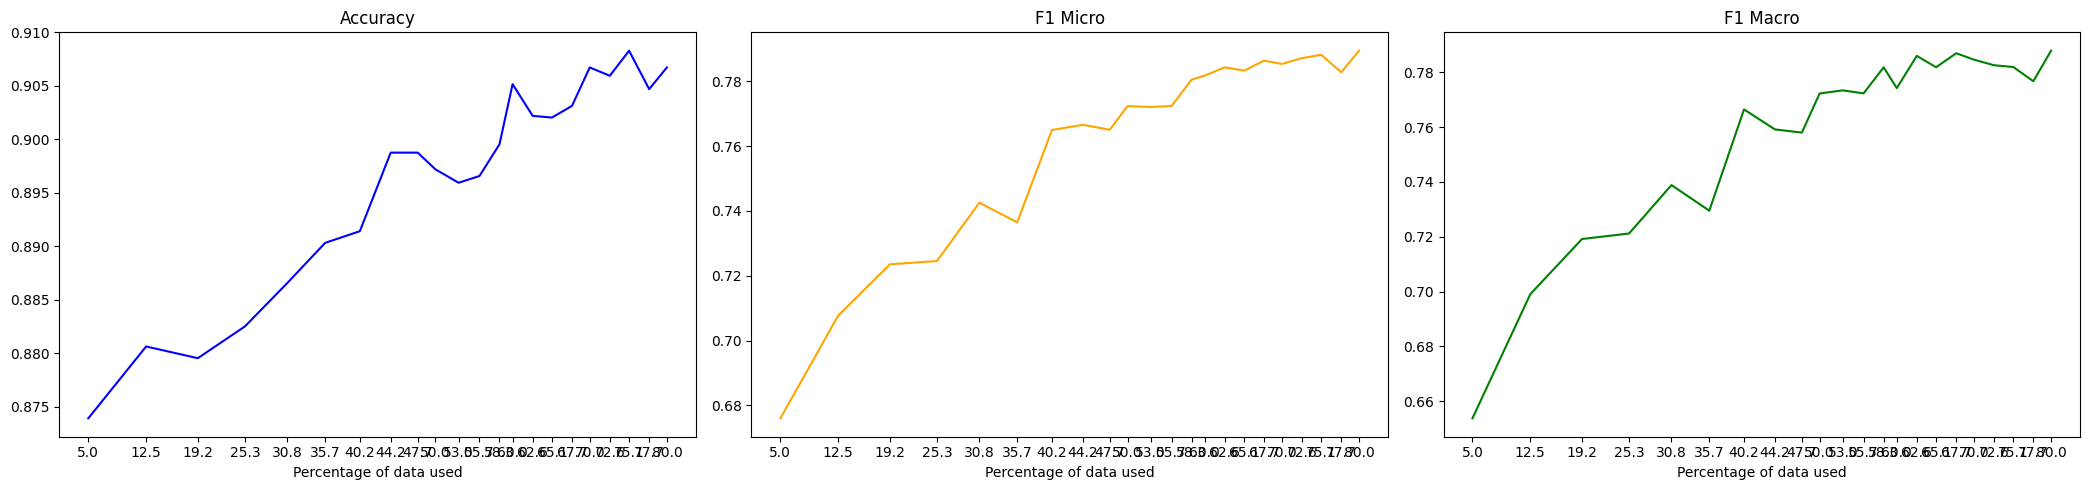

In [20]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.793, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8236, F1 Micro: 0.2957, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3572, Accuracy: 0.8389, F1 Micro: 0.4256, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2998, Accuracy: 0.8417, F1 Micro: 0.4468, F1 Macro: 0.3645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2759, Accuracy: 0.8531, F1 Micro: 0.5406, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.8637, F1 Micro: 0.6152, F1 Macro: 0.5822
Epoch 8/10, Train Loss: 0.1944, Accuracy: 0.8647, F1 Micro: 0.5957, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1747, Accuracy: 0.8687, F1 Micro: 0.643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5581, Accuracy: 0.8333, F1 Micro: 0.4673, F1 Macro: 0.445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3905, Accuracy: 0.86, F1 Micro: 0.6161, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3003, Accuracy: 0.8684, F1 Micro: 0.6317, F1 Macro: 0.6217
Epoch 4/10, Train Loss: 0.249, Accuracy: 0.8687, F1 Micro: 0.6185, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2114, Accuracy: 0.8752, F1 Micro: 0.6678, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.8766, F1 Micro: 0.6855, F1 Macro: 0.6789
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.8744, F1 Micro: 0.6579, F1 Macro: 0.6411
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.8788, F1 Micro: 0.6641, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.8778, F1 Micro: 0.7049, F1 Macro: 0.6985
Epoch 10/10, Train Loss: 0.0671, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4891, Accuracy: 0.8259, F1 Micro: 0.6287, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3008, Accuracy: 0.8637, F1 Micro: 0.6351, F1 Macro: 0.6031
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.8716, F1 Micro: 0.6311, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.8811, F1 Micro: 0.692, F1 Macro: 0.686
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.8814, F1 Micro: 0.6852, F1 Macro: 0.6747
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.8833, F1 Micro: 0.6897, F1 Macro: 0.677
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.8802, F1 Micro: 0.664, F1 Macro: 0.6423
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.8833, F1 Micro: 0.6912, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.885, F1 Micro: 0.6895, F1 Macro: 0.6787
Epoch 10/10, Train Loss: 0.0544, Accuracy: 0.8833, F1 Micro: 0.6863, F1 Macro: 0.6798

 Iteration 1496: Accuracy: 0.8811, F1 Micro: 0.692, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8447, F1 Micro: 0.6427, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.8741, F1 Micro: 0.701, F1 Macro: 0.6922
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.8733, F1 Micro: 0.6322, F1 Macro: 0.6086
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.8802, F1 Micro: 0.6858, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.8892, F1 Micro: 0.7163, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.8903, F1 Micro: 0.7292, F1 Macro: 0.7209
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.8903, F1 Micro: 0.7221, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.8866, F1 Micro: 0.7301, F1 Macro: 0.723
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.8878, F1 Micro: 0.7043, F1 Macro: 0.6946
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.8913, F1 Micro: 0.7225, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4367, Accuracy: 0.8406, F1 Micro: 0.6083, F1 Macro: 0.5322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.8808, F1 Micro: 0.7051, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.8877, F1 Micro: 0.71, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.8931, F1 Micro: 0.7204, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.8933, F1 Micro: 0.7297, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.8938, F1 Micro: 0.7387, F1 Macro: 0.7271
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.8906, F1 Micro: 0.7148, F1 Macro: 0.6967
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.8919, F1 Micro: 0.718, F1 Macro: 0.7066
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.8931, F1 Micro: 0.7176, F1 Macro: 0.7006
Epoch 10/10, Train Loss: 0.0373, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4369, Accuracy: 0.8358, F1 Micro: 0.6694, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.8839, F1 Micro: 0.7249, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2252, Accuracy: 0.8953, F1 Micro: 0.7498, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9003, F1 Micro: 0.7585, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.8977, F1 Micro: 0.766, F1 Macro: 0.763
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.8959, F1 Micro: 0.7481, F1 Macro: 0.7345
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.8942, F1 Micro: 0.7327, F1 Macro: 0.7175
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.898, F1 Micro: 0.7505, F1 Macro: 0.7436
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.8967, F1 Micro: 0.7466, F1 Macro: 0.7363
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.8983, F1 Micro: 0.7529, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4346, Accuracy: 0.8656, F1 Micro: 0.6598, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2752, Accuracy: 0.8856, F1 Micro: 0.7413, F1 Macro: 0.7309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2182, Accuracy: 0.8945, F1 Micro: 0.7636, F1 Macro: 0.7651
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.8998, F1 Micro: 0.7391, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9019, F1 Micro: 0.7713, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.897, F1 Micro: 0.7679, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9022, F1 Micro: 0.7602, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9041, F1 Micro: 0.7734, F1 Macro: 0.7686
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9006, F1 Micro: 0.7641, F1 Macro: 0.7578
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.9014, F1 Micro: 0.7641, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4242, Accuracy: 0.8666, F1 Micro: 0.7069, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.8963, F1 Micro: 0.7473, F1 Macro: 0.7288
Epoch 3/10, Train Loss: 0.2265, Accuracy: 0.8989, F1 Micro: 0.7438, F1 Macro: 0.7332
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.8988, F1 Micro: 0.7277, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.902, F1 Micro: 0.7615, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9005, F1 Micro: 0.7678, F1 Macro: 0.7604
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9002, F1 Micro: 0.7549, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9014, F1 Micro: 0.7715, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9023, F1 Micro: 0.7646, F1 Macro: 0.7578
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.9, F1 Micro: 0.7589, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4308, Accuracy: 0.873, F1 Micro: 0.7045, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.8983, F1 Micro: 0.7535, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2325, Accuracy: 0.898, F1 Micro: 0.7563, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9033, F1 Micro: 0.7681, F1 Macro: 0.7629
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9022, F1 Micro: 0.7541, F1 Macro: 0.7439
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9009, F1 Micro: 0.7529, F1 Macro: 0.7412
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.8997, F1 Micro: 0.7615, F1 Macro: 0.7521
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.8991, F1 Micro: 0.7551, F1 Macro: 0.7499
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9033, F1 Micro: 0.7635, F1 Macro: 0.7538
Epoch 10/10, Train Loss: 0.0394, Accuracy: 0.9019, F1 Micro: 0.7618, F1 Macro: 0.7501

 Iteration 3711: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4263, Accuracy: 0.8753, F1 Micro: 0.6769, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2797, Accuracy: 0.8995, F1 Micro: 0.7495, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.9058, F1 Micro: 0.7662, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.897, F1 Micro: 0.7764, F1 Macro: 0.7802
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.8998, F1 Micro: 0.7499, F1 Macro: 0.7403
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.898, F1 Micro: 0.7612, F1 Macro: 0.7593
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9006, F1 Micro: 0.7537, F1 Macro: 0.7462
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9016, F1 Micro: 0.7726, F1 Macro: 0.7675
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9031, F1 Micro: 0.761, F1 Macro: 0.7558
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.9027, F1 Micro: 0.7621, F1 Macro: 0.7529

 Iteration 3886: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.8853, F1 Micro: 0.7181, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.9005, F1 Micro: 0.7659, F1 Macro: 0.7591
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.9042, F1 Micro: 0.7636, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.9008, F1 Micro: 0.7773, F1 Macro: 0.7734
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9033, F1 Micro: 0.7688, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9033, F1 Micro: 0.7589, F1 Macro: 0.7496
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9039, F1 Micro: 0.7731, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9036, F1 Micro: 0.7752, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9061, F1 Micro: 0.7814, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.905, F1 Micro: 0.7776, F1 Macro: 0.7705

 Iteration 4120: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8819, F1 Micro: 0.707, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.8989, F1 Micro: 0.7677, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9059, F1 Micro: 0.777, F1 Macro: 0.7679
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9011, F1 Micro: 0.7426, F1 Macro: 0.7316
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9, F1 Micro: 0.7647, F1 Macro: 0.7567
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9011, F1 Micro: 0.7725, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9047, F1 Micro: 0.7729, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9044, F1 Micro: 0.7673, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9006, F1 Micro: 0.7719, F1 Macro: 0.7655
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.9055, F1 Micro: 0.7733, F1 Macro: 0.7681

 Iteration 4330: Accuracy: 0.9059, F1 Micro: 0.777, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4065, Accuracy: 0.8786, F1 Micro: 0.7312, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.8944, F1 Micro: 0.7702, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9056, F1 Micro: 0.7832, F1 Macro: 0.7799
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9031, F1 Micro: 0.7805, F1 Macro: 0.7709
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9028, F1 Micro: 0.7674, F1 Macro: 0.7551
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9053, F1 Micro: 0.7713, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9084, F1 Micro: 0.7727, F1 Macro: 0.7627
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9045, F1 Micro: 0.7697, F1 Macro: 0.761
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9055, F1 Micro: 0.7794, F1 Macro: 0.7729
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.9034, F1 Micro: 0.7614, F1 Macro: 0.7569

 Iteration 4530: Accuracy: 0.9056, F1 Micro: 0.783

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8828, F1 Micro: 0.6968, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.8994, F1 Micro: 0.7737, F1 Macro: 0.7705
Epoch 3/10, Train Loss: 0.2257, Accuracy: 0.9031, F1 Micro: 0.7486, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9047, F1 Micro: 0.7795, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9052, F1 Micro: 0.7811, F1 Macro: 0.7736
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9006, F1 Micro: 0.7454, F1 Macro: 0.7295
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9073, F1 Micro: 0.7822, F1 Macro: 0.7771
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9047, F1 Micro: 0.772, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9053, F1 Micro: 0.7783, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9025, F1 Micro: 0.7709, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8892, F1 Micro: 0.7385, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.9017, F1 Micro: 0.7688, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9072, F1 Micro: 0.779, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.907, F1 Micro: 0.7828, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9048, F1 Micro: 0.7837, F1 Macro: 0.7806
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9059, F1 Micro: 0.7762, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9062, F1 Micro: 0.7736, F1 Macro: 0.7658
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.905, F1 Micro: 0.775, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9059, F1 Micro: 0.778, F1 Macro: 0.7708
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.905, F1 Micro: 0.7778, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8869, F1 Micro: 0.7436, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2546, Accuracy: 0.8984, F1 Micro: 0.7517, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9058, F1 Micro: 0.7691, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.907, F1 Micro: 0.7882, F1 Macro: 0.7863
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9067, F1 Micro: 0.7799, F1 Macro: 0.7707
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9042, F1 Micro: 0.7781, F1 Macro: 0.7756
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9039, F1 Micro: 0.7639, F1 Macro: 0.7547
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9084, F1 Micro: 0.7828, F1 Macro: 0.7816
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9058, F1 Micro: 0.7789, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9061, F1 Micro: 0.7833, F1 Macro: 0.7793

 Iteration 5063: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8944, F1 Micro: 0.7504, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9013, F1 Micro: 0.7666, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9019, F1 Micro: 0.7798, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9056, F1 Micro: 0.7838, F1 Macro: 0.7812
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.91, F1 Micro: 0.7812, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9041, F1 Micro: 0.7759, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9077, F1 Micro: 0.7792, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9047, F1 Micro: 0.7689, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9078, F1 Micro: 0.7876, F1 Macro: 0.7828
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9047, F1 Micro: 0.7838, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3758, Accuracy: 0.8895, F1 Micro: 0.7474, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2511, Accuracy: 0.8992, F1 Micro: 0.7503, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9059, F1 Micro: 0.7871, F1 Macro: 0.7853
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9052, F1 Micro: 0.7834, F1 Macro: 0.7799
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9041, F1 Micro: 0.7771, F1 Macro: 0.7758
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9044, F1 Micro: 0.7771, F1 Macro: 0.7714
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9044, F1 Micro: 0.7752, F1 Macro: 0.7677
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9038, F1 Micro: 0.7795, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.903, F1 Micro: 0.7714, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9066, F1 Micro: 0.775, F1 Macro: 0.7661

 Iteration 5441: Accuracy: 0.9059, F1 Micro: 0.7871

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.8855, F1 Micro: 0.6939, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.9023, F1 Micro: 0.7646, F1 Macro: 0.7571
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9036, F1 Micro: 0.7608, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.908, F1 Micro: 0.784, F1 Macro: 0.7799
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9075, F1 Micro: 0.7815, F1 Macro: 0.7721
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.905, F1 Micro: 0.7819, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9038, F1 Micro: 0.7638, F1 Macro: 0.749
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9064, F1 Micro: 0.7819, F1 Macro: 0.7812
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9034, F1 Micro: 0.7641, F1 Macro: 0.7526
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9027, F1 Micro: 0.7787, F1 Macro: 0.7755

 Iteration 5641: Accuracy: 0.908, F1 Micro: 0.784, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3622, Accuracy: 0.8933, F1 Micro: 0.7447, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.9025, F1 Micro: 0.7701, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9053, F1 Micro: 0.7856, F1 Macro: 0.7803
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9038, F1 Micro: 0.782, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9039, F1 Micro: 0.7721, F1 Macro: 0.7683
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9048, F1 Micro: 0.7747, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9045, F1 Micro: 0.78, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9039, F1 Micro: 0.7706, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9056, F1 Micro: 0.783, F1 Macro: 0.7802
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9033, F1 Micro: 0.7784, F1 Macro: 0.7731

 Iteration 5841: Accuracy: 0.9053, F1 Micro: 0.7856, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3686, Accuracy: 0.892, F1 Micro: 0.7397, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2336, Accuracy: 0.9009, F1 Micro: 0.7695, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9041, F1 Micro: 0.7865, F1 Macro: 0.7858
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9064, F1 Micro: 0.7866, F1 Macro: 0.7845
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9017, F1 Micro: 0.783, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.905, F1 Micro: 0.7802, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9039, F1 Micro: 0.7768, F1 Macro: 0.7704
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9002, F1 Micro: 0.7725, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9033, F1 Micro: 0.7841, F1 Macro: 0.7823
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9019, F1 Micro: 0.773, F1 Macro: 0.7655

 Iteration 6041: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.353, Accuracy: 0.8947, F1 Micro: 0.7422, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2311, Accuracy: 0.8994, F1 Micro: 0.7597, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1893, Accuracy: 0.9073, F1 Micro: 0.786, F1 Macro: 0.7776
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9034, F1 Micro: 0.7668, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9084, F1 Micro: 0.7866, F1 Macro: 0.7803
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.9061, F1 Micro: 0.7786, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9034, F1 Micro: 0.7838, F1 Macro: 0.7817
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9047, F1 Micro: 0.7767, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9011, F1 Micro: 0.7751, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9025, F1 Micro: 0.7795, F1 Macro: 0.7756

 Iteration 6218: Ac

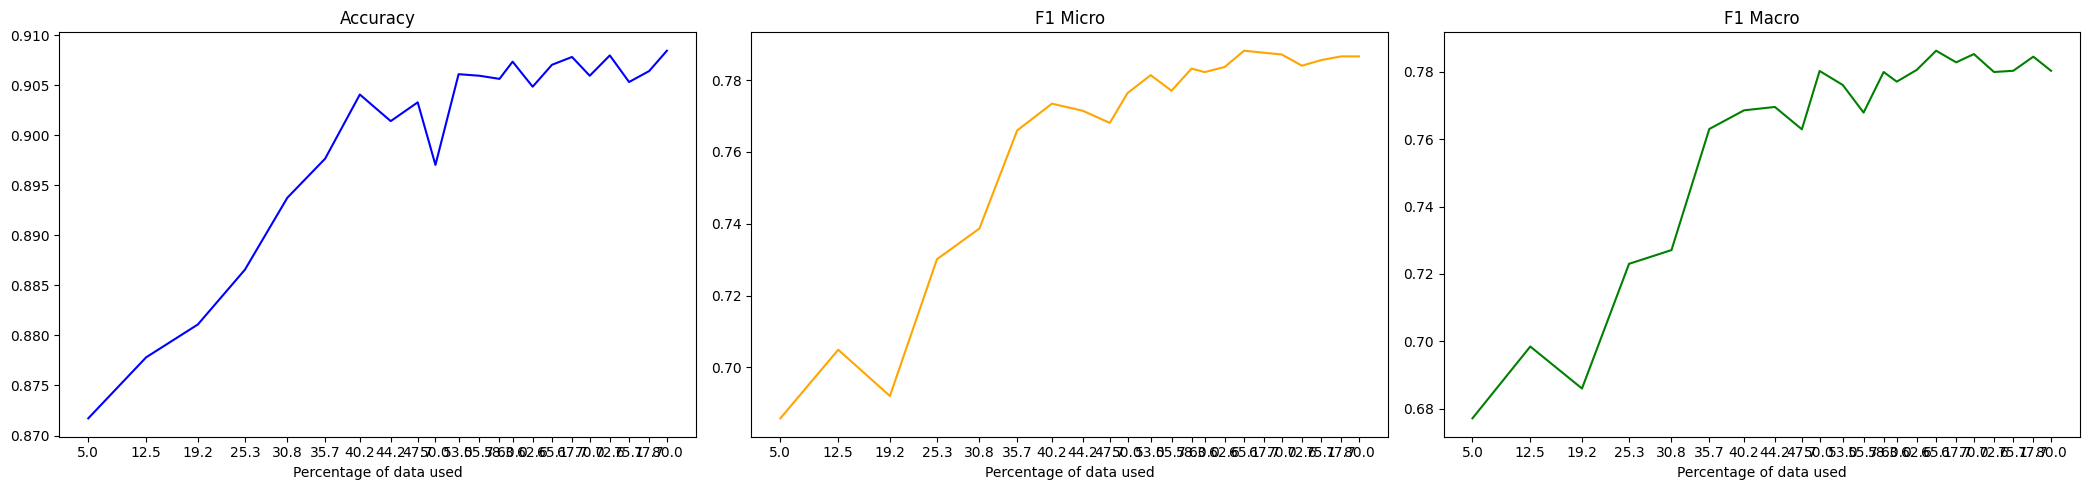

In [21]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6187, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8111, F1 Micro: 0.2051, F1 Macro: 0.1483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3885, Accuracy: 0.8291, F1 Micro: 0.3587, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8389, F1 Micro: 0.4418, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.855, F1 Micro: 0.5455, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8719, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.8605, F1 Micro: 0.5802, F1 Macro: 0.5478
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.867, F1 Micro: 0.6343, F1 Macro: 0.6221
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.8037, F1 Micro: 0.3298, F1 Macro: 0.1758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.8267, F1 Micro: 0.3418, F1 Macro: 0.2104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.8347, F1 Micro: 0.394, F1 Macro: 0.3014
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.8559, F1 Micro: 0.5917, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.8644, F1 Micro: 0.609, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.8734, F1 Micro: 0.6939, F1 Macro: 0.6783
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.87, F1 Micro: 0.6683, F1 Macro: 0.6463
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.8702, F1 Micro: 0.6593, F1 Macro: 0.6407
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.8742, F1 Micro: 0.6812, F1 Macro: 0.6689
Epoch 10/10, Train Loss: 0.0387, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3878, Accuracy: 0.8158, F1 Micro: 0.3461, F1 Macro: 0.1931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2192, Accuracy: 0.8297, F1 Micro: 0.3663, F1 Macro: 0.2193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1511, Accuracy: 0.8578, F1 Micro: 0.5473, F1 Macro: 0.4775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1204, Accuracy: 0.8675, F1 Micro: 0.611, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0961, Accuracy: 0.8723, F1 Micro: 0.6519, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0663, Accuracy: 0.8788, F1 Micro: 0.6886, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0501, Accuracy: 0.8797, F1 Micro: 0.6918, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.8786, F1 Micro: 0.723, F1 Macro: 0.7141
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.8708, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3472, Accuracy: 0.8255, F1 Micro: 0.3547, F1 Macro: 0.2086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1948, Accuracy: 0.8405, F1 Micro: 0.4399, F1 Macro: 0.3503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1259, Accuracy: 0.8758, F1 Micro: 0.6658, F1 Macro: 0.6168
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0948, Accuracy: 0.8852, F1 Micro: 0.7112, F1 Macro: 0.6914
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0757, Accuracy: 0.8855, F1 Micro: 0.733, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0566, Accuracy: 0.888, F1 Micro: 0.7399, F1 Macro: 0.7324
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.8827, F1 Micro: 0.7165, F1 Macro: 0.7075
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.885, F1 Micro: 0.7246, F1 Macro: 0.7189
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.8838, F1 Micro: 0.7005, F1 Macro: 0.6792
Epoch 10/10, Train Loss: 0.0266, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3287, Accuracy: 0.8294, F1 Micro: 0.3629, F1 Macro: 0.231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1698, Accuracy: 0.8511, F1 Micro: 0.5184, F1 Macro: 0.4335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1218, Accuracy: 0.8767, F1 Micro: 0.6609, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0963, Accuracy: 0.8886, F1 Micro: 0.73, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0714, Accuracy: 0.8886, F1 Micro: 0.7382, F1 Macro: 0.7248
Epoch 6/10, Train Loss: 0.0545, Accuracy: 0.8809, F1 Micro: 0.6947, F1 Macro: 0.6805
Epoch 7/10, Train Loss: 0.041, Accuracy: 0.883, F1 Micro: 0.7204, F1 Macro: 0.7081
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.8867, F1 Micro: 0.7206, F1 Macro: 0.7028
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.8817, F1 Micro: 0.7011, F1 Macro: 0.6845
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0222, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3197, Accuracy: 0.8389, F1 Micro: 0.4282, F1 Macro: 0.3403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1814, Accuracy: 0.8598, F1 Micro: 0.5791, F1 Macro: 0.4911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1234, Accuracy: 0.8778, F1 Micro: 0.6971, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0978, Accuracy: 0.8819, F1 Micro: 0.7347, F1 Macro: 0.7287
Epoch 5/10, Train Loss: 0.0803, Accuracy: 0.8853, F1 Micro: 0.6994, F1 Macro: 0.6699
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.8819, F1 Micro: 0.7198, F1 Macro: 0.7096
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.8855, F1 Micro: 0.7286, F1 Macro: 0.7222
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.88, F1 Micro: 0.7344, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.8884, F1 Micro: 0.7472, F1 Macro: 0.7429
Epoch 10/10, Train Loss: 0.0209, Accuracy: 0.8844, F1 Micro: 0.7368, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3334, Accuracy: 0.8427, F1 Micro: 0.4542, F1 Macro: 0.3665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1855, Accuracy: 0.8648, F1 Micro: 0.6095, F1 Macro: 0.537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1364, Accuracy: 0.8869, F1 Micro: 0.7258, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1094, Accuracy: 0.8914, F1 Micro: 0.7486, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0832, Accuracy: 0.8877, F1 Micro: 0.7582, F1 Macro: 0.7562
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.8845, F1 Micro: 0.7431, F1 Macro: 0.7396
Epoch 7/10, Train Loss: 0.0498, Accuracy: 0.8908, F1 Micro: 0.7251, F1 Macro: 0.6982
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.8816, F1 Micro: 0.7487, F1 Macro: 0.7496
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.8881, F1 Micro: 0.7556, F1 Macro: 0.7563
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.8938, F1 Micro: 0.75, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3259, Accuracy: 0.853, F1 Micro: 0.5197, F1 Macro: 0.4329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1734, Accuracy: 0.8755, F1 Micro: 0.6697, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1341, Accuracy: 0.8792, F1 Micro: 0.7441, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1072, Accuracy: 0.8903, F1 Micro: 0.7449, F1 Macro: 0.7443
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0851, Accuracy: 0.8913, F1 Micro: 0.7496, F1 Macro: 0.7472
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.8941, F1 Micro: 0.7442, F1 Macro: 0.7385
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0405, Accuracy: 0.8936, F1 Micro: 0.7646, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.0324, Accuracy: 0.8934, F1 Micro: 0.7566, F1 Macro: 0.7571
Epoch 9/10, Train Loss: 0.0232, Accuracy: 0.8888, F1 Micro: 0.7572, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0218, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.8516, F1 Micro: 0.5103, F1 Macro: 0.4245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.8811, F1 Micro: 0.7031, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.8855, F1 Micro: 0.7216, F1 Macro: 0.6749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1122, Accuracy: 0.8892, F1 Micro: 0.7398, F1 Macro: 0.7317
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0806, Accuracy: 0.8983, F1 Micro: 0.755, F1 Macro: 0.7474
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.8898, F1 Micro: 0.7329, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0461, Accuracy: 0.8847, F1 Micro: 0.7579, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.8922, F1 Micro: 0.7394, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.8973, F1 Micro: 0.758, F1 Macro: 0.754
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.8491, F1 Micro: 0.5076, F1 Macro: 0.4276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1754, Accuracy: 0.8822, F1 Micro: 0.6646, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1461, Accuracy: 0.8927, F1 Micro: 0.7615, F1 Macro: 0.7538
Epoch 4/10, Train Loss: 0.1088, Accuracy: 0.8906, F1 Micro: 0.7295, F1 Macro: 0.716
Epoch 5/10, Train Loss: 0.0824, Accuracy: 0.89, F1 Micro: 0.7511, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0614, Accuracy: 0.8917, F1 Micro: 0.7624, F1 Macro: 0.7641
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.8884, F1 Micro: 0.7561, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0343, Accuracy: 0.8911, F1 Micro: 0.7673, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.8961, F1 Micro: 0.7672, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0213, Accuracy: 0.8931, F1 Micro: 0.7649, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.8539, F1 Micro: 0.5198, F1 Macro: 0.4345
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1889, Accuracy: 0.8827, F1 Micro: 0.7016, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.8903, F1 Micro: 0.7203, F1 Macro: 0.6934
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1165, Accuracy: 0.8942, F1 Micro: 0.7678, F1 Macro: 0.7674
Epoch 5/10, Train Loss: 0.089, Accuracy: 0.8859, F1 Micro: 0.7573, F1 Macro: 0.7565
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.8805, F1 Micro: 0.7547, F1 Macro: 0.7574
Epoch 7/10, Train Loss: 0.0455, Accuracy: 0.8892, F1 Micro: 0.7566, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.8838, F1 Micro: 0.7569, F1 Macro: 0.7583
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.895, F1 Micro: 0.7615, F1 Macro: 0.7602
Epoch 10/10, Train Loss: 0.0209, Accuracy: 0.8863, F1 Micro: 0.7594, F1 Macro: 0.7637

 Iteration 4120: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3317, Accuracy: 0.8602, F1 Micro: 0.5606, F1 Macro: 0.472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1847, Accuracy: 0.8778, F1 Micro: 0.6543, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1504, Accuracy: 0.8964, F1 Micro: 0.7653, F1 Macro: 0.7613
Epoch 4/10, Train Loss: 0.1198, Accuracy: 0.8869, F1 Micro: 0.7648, F1 Macro: 0.7631
Epoch 5/10, Train Loss: 0.0937, Accuracy: 0.8864, F1 Micro: 0.759, F1 Macro: 0.7607
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.8975, F1 Micro: 0.757, F1 Macro: 0.7495
Epoch 7/10, Train Loss: 0.0456, Accuracy: 0.8964, F1 Micro: 0.7628, F1 Macro: 0.7609
Epoch 8/10, Train Loss: 0.0314, Accuracy: 0.8973, F1 Micro: 0.7573, F1 Macro: 0.747
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.8934, F1 Micro: 0.763, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.8963, F1 Micro: 0.7683, F1 Macro: 0.7702

 Iteration 4330: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3449, Accuracy: 0.8614, F1 Micro: 0.5782, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.8867, F1 Micro: 0.7308, F1 Macro: 0.7065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1496, Accuracy: 0.8908, F1 Micro: 0.7343, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.8981, F1 Micro: 0.7463, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0826, Accuracy: 0.8977, F1 Micro: 0.7719, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.8934, F1 Micro: 0.769, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.8952, F1 Micro: 0.7648, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.892, F1 Micro: 0.759, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.8991, F1 Micro: 0.7755, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0223, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3483, Accuracy: 0.8647, F1 Micro: 0.5942, F1 Macro: 0.5037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2012, Accuracy: 0.8886, F1 Micro: 0.7209, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.8966, F1 Micro: 0.7502, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1278, Accuracy: 0.9058, F1 Micro: 0.7758, F1 Macro: 0.772
Epoch 5/10, Train Loss: 0.0977, Accuracy: 0.8973, F1 Micro: 0.7367, F1 Macro: 0.7091
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.8959, F1 Micro: 0.7713, F1 Macro: 0.7716
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.8989, F1 Micro: 0.7695, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9002, F1 Micro: 0.7681, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.8986, F1 Micro: 0.7706, F1 Macro: 0.7681
Epoch 10/10, Train Loss: 0.0235, Accuracy: 0.8967, F1 Micro: 0.7688, F1 Macro: 0.7662

 Iteration 4663: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3466, Accuracy: 0.8759, F1 Micro: 0.6697, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2028, Accuracy: 0.8922, F1 Micro: 0.7425, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.8963, F1 Micro: 0.7622, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.8994, F1 Micro: 0.7678, F1 Macro: 0.7581
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9003, F1 Micro: 0.7658, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9023, F1 Micro: 0.7593, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.8964, F1 Micro: 0.7683, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9011, F1 Micro: 0.7758, F1 Macro: 0.774
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.903, F1 Micro: 0.7744, F1 Macro: 0.7691
Epoch 10/10, Train Loss: 0.0236, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3445, Accuracy: 0.8748, F1 Micro: 0.6534, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.8952, F1 Micro: 0.762, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9023, F1 Micro: 0.7826, F1 Macro: 0.7796
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9056, F1 Micro: 0.7741, F1 Macro: 0.7671
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.8994, F1 Micro: 0.7713, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.0732, Accuracy: 0.9042, F1 Micro: 0.7813, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9008, F1 Micro: 0.7707, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9014, F1 Micro: 0.7813, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9014, F1 Micro: 0.7782, F1 Macro: 0.7775
Epoch 10/10, Train Loss: 0.0214, Accuracy: 0.9055, F1 Micro: 0.781, F1 Macro: 0.7837

 Iteration 5063: Accuracy: 0.9023, F1 Micro: 0.7826, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.347, Accuracy: 0.8797, F1 Micro: 0.6875, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.216, Accuracy: 0.8934, F1 Micro: 0.7298, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.8986, F1 Micro: 0.7608, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.9014, F1 Micro: 0.7667, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1065, Accuracy: 0.9008, F1 Micro: 0.767, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9044, F1 Micro: 0.7701, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9023, F1 Micro: 0.7701, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.8992, F1 Micro: 0.7707, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9011, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3517, Accuracy: 0.8834, F1 Micro: 0.6933, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2121, Accuracy: 0.8972, F1 Micro: 0.7494, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9025, F1 Micro: 0.7528, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9067, F1 Micro: 0.7828, F1 Macro: 0.7777
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.8988, F1 Micro: 0.7791, F1 Macro: 0.7792
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.9072, F1 Micro: 0.7789, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.8994, F1 Micro: 0.7779, F1 Macro: 0.7794
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9047, F1 Micro: 0.7764, F1 Macro: 0.7757
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9023, F1 Micro: 0.7761, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.027, Accuracy: 0.9013, F1 Micro: 0.7675, F1 Macro: 0.7618

 Iteration 5441: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.353, Accuracy: 0.8794, F1 Micro: 0.7067, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2279, Accuracy: 0.8931, F1 Micro: 0.7656, F1 Macro: 0.7533
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.8984, F1 Micro: 0.7408, F1 Macro: 0.7231
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9027, F1 Micro: 0.7806, F1 Macro: 0.7781
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.9044, F1 Micro: 0.7763, F1 Macro: 0.7743
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9055, F1 Micro: 0.7758, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9005, F1 Micro: 0.7652, F1 Macro: 0.7582
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9016, F1 Micro: 0.7788, F1 Macro: 0.777
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.8991, F1 Micro: 0.7744, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0255, Accuracy: 0.8997, F1 Micro: 0.7706, F1 Macro: 0.7693

 Iteration 5641: Accuracy: 0.9027, F1 Micro: 0.7806

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3651, Accuracy: 0.8833, F1 Micro: 0.6955, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2254, Accuracy: 0.8981, F1 Micro: 0.7498, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9042, F1 Micro: 0.7708, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9006, F1 Micro: 0.7793, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9031, F1 Micro: 0.7669, F1 Macro: 0.755
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.8995, F1 Micro: 0.7691, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9055, F1 Micro: 0.7757, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9031, F1 Micro: 0.7755, F1 Macro: 0.7721
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9008, F1 Micro: 0.7717, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9022, F1 Micro: 0.7699, F1 Macro: 0.7646

 Iteration 5841: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3575, Accuracy: 0.8922, F1 Micro: 0.7408, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2256, Accuracy: 0.9011, F1 Micro: 0.7667, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.8991, F1 Micro: 0.7812, F1 Macro: 0.782
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9081, F1 Micro: 0.7752, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9048, F1 Micro: 0.7824, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.908, F1 Micro: 0.7906, F1 Macro: 0.7885
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9056, F1 Micro: 0.7879, F1 Macro: 0.7884
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.9064, F1 Micro: 0.7754, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9086, F1 Micro: 0.7829, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9027, F1 Micro: 0.7724, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.8905, F1 Micro: 0.7497, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.9025, F1 Micro: 0.776, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9039, F1 Micro: 0.7829, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9062, F1 Micro: 0.7839, F1 Macro: 0.7772
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9067, F1 Micro: 0.779, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9034, F1 Micro: 0.7751, F1 Macro: 0.7716
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9042, F1 Micro: 0.777, F1 Macro: 0.7746
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9011, F1 Micro: 0.7795, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9047, F1 Micro: 0.779, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9039, F1 Micro: 0.7706, F1 Macro: 0.7669

 Iteration 6218: Accur

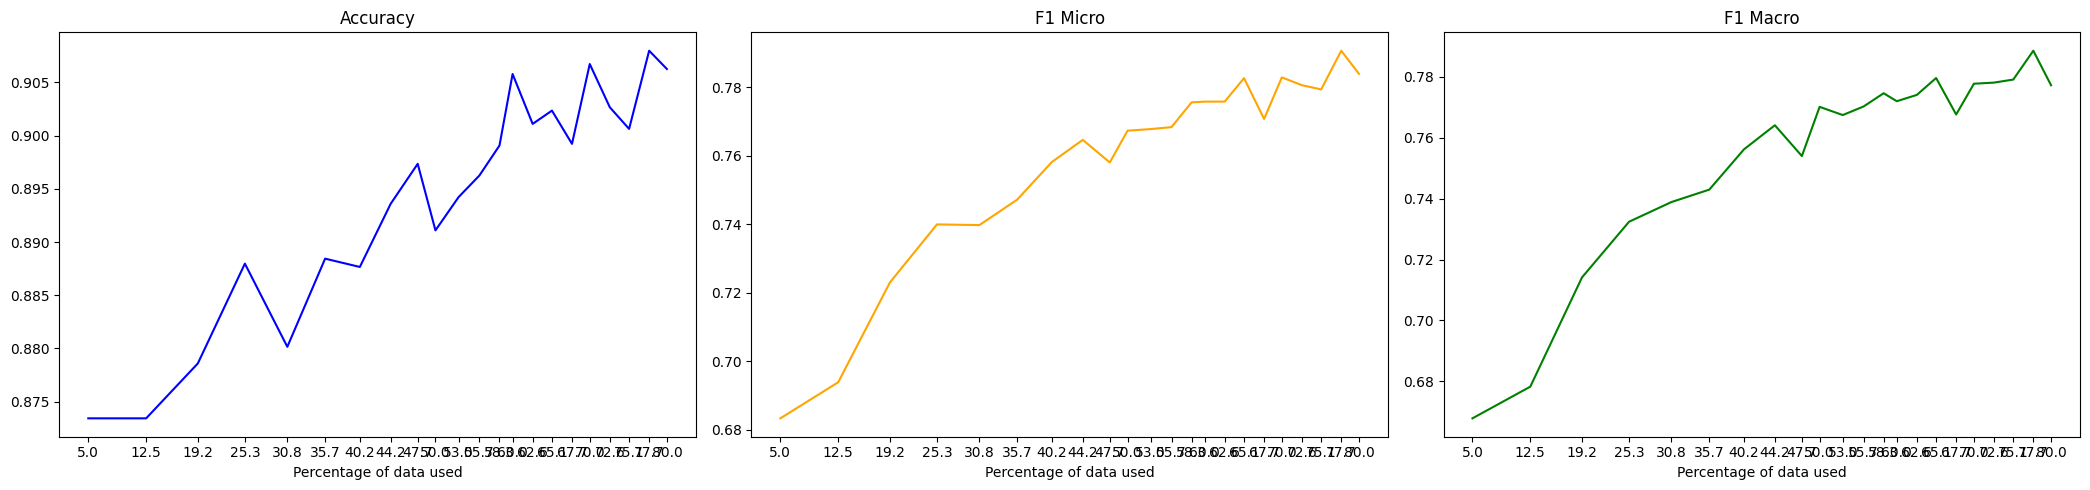

In [22]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.79, F1 Micro: 0.0303, F1 Macro: 0.0269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4288, Accuracy: 0.8306, F1 Micro: 0.3593, F1 Macro: 0.2395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3915, Accuracy: 0.835, F1 Micro: 0.4413, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3345, Accuracy: 0.8445, F1 Micro: 0.4826, F1 Macro: 0.381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.8612, F1 Micro: 0.6162, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2536, Accuracy: 0.8698, F1 Micro: 0.6548, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2078, Accuracy: 0.8711, F1 Micro: 0.6642, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.7887, F1 Micro: 0.3247, F1 Macro: 0.1614
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.828, F1 Micro: 0.3535, F1 Macro: 0.2211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.8391, F1 Micro: 0.4707, F1 Macro: 0.3592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.848, F1 Micro: 0.5195, F1 Macro: 0.4611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.872, F1 Micro: 0.6858, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.8777, F1 Micro: 0.6911, F1 Macro: 0.6682
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.8739, F1 Micro: 0.6689, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.8717, F1 Micro: 0.7061, F1 Macro: 0.697
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.8695, F1 Micro: 0.6355, F1 Macro: 0.5928
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3553, Accuracy: 0.8161, F1 Micro: 0.3501, F1 Macro: 0.1942
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.8316, F1 Micro: 0.3957, F1 Macro: 0.2831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1447, Accuracy: 0.8636, F1 Micro: 0.6048, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1187, Accuracy: 0.8717, F1 Micro: 0.6432, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0882, Accuracy: 0.8813, F1 Micro: 0.6958, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0684, Accuracy: 0.8827, F1 Micro: 0.7152, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.8806, F1 Micro: 0.7175, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.8772, F1 Micro: 0.724, F1 Macro: 0.7164
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.8788, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3413, Accuracy: 0.8266, F1 Micro: 0.3516, F1 Macro: 0.2164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.8455, F1 Micro: 0.4997, F1 Macro: 0.3953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1356, Accuracy: 0.8678, F1 Micro: 0.6043, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1047, Accuracy: 0.8816, F1 Micro: 0.7289, F1 Macro: 0.7107
Epoch 5/10, Train Loss: 0.0806, Accuracy: 0.8864, F1 Micro: 0.7146, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.8789, F1 Micro: 0.7377, F1 Macro: 0.7338
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.8891, F1 Micro: 0.73, F1 Macro: 0.7082
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.8861, F1 Micro: 0.7064, F1 Macro: 0.6832
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.8884, F1 Micro: 0.7338, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0268, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3183, Accuracy: 0.8347, F1 Micro: 0.4116, F1 Macro: 0.3154
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.848, F1 Micro: 0.52, F1 Macro: 0.4228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1351, Accuracy: 0.8772, F1 Micro: 0.7045, F1 Macro: 0.6423
Epoch 4/10, Train Loss: 0.1035, Accuracy: 0.8825, F1 Micro: 0.6843, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.084, Accuracy: 0.8872, F1 Micro: 0.7429, F1 Macro: 0.7379
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.8848, F1 Micro: 0.7034, F1 Macro: 0.6622
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.8855, F1 Micro: 0.7368, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.0405, Accuracy: 0.8872, F1 Micro: 0.7412, F1 Macro: 0.7316
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.8855, F1 Micro: 0.73, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.8872, F1 Micro: 0.7502, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3173, Accuracy: 0.8398, F1 Micro: 0.4692, F1 Macro: 0.3677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.8548, F1 Micro: 0.5717, F1 Macro: 0.478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1368, Accuracy: 0.8842, F1 Micro: 0.7281, F1 Macro: 0.7053
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.106, Accuracy: 0.8853, F1 Micro: 0.7301, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.088, Accuracy: 0.8886, F1 Micro: 0.7346, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0634, Accuracy: 0.8894, F1 Micro: 0.75, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0487, Accuracy: 0.8913, F1 Micro: 0.7525, F1 Macro: 0.7456
Epoch 8/10, Train Loss: 0.0338, Accuracy: 0.8859, F1 Micro: 0.7378, F1 Macro: 0.7262
Epoch 9/10, Train Loss: 0.0278, Accuracy: 0.8884, F1 Micro: 0.739, F1 Macro: 0.7358
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3116, Accuracy: 0.8428, F1 Micro: 0.4955, F1 Macro: 0.3905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1901, Accuracy: 0.8612, F1 Micro: 0.5904, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.8842, F1 Micro: 0.7297, F1 Macro: 0.7223
Epoch 4/10, Train Loss: 0.1106, Accuracy: 0.8883, F1 Micro: 0.7076, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0861, Accuracy: 0.8914, F1 Micro: 0.7301, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.8905, F1 Micro: 0.7395, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.8944, F1 Micro: 0.7428, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.8919, F1 Micro: 0.7594, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0259, Accuracy: 0.895, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3215, Accuracy: 0.8495, F1 Micro: 0.5282, F1 Macro: 0.4314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.8692, F1 Micro: 0.6061, F1 Macro: 0.5145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1402, Accuracy: 0.8839, F1 Micro: 0.7029, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1078, Accuracy: 0.8936, F1 Micro: 0.732, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0793, Accuracy: 0.8853, F1 Micro: 0.754, F1 Macro: 0.7509
Epoch 6/10, Train Loss: 0.0598, Accuracy: 0.8856, F1 Micro: 0.7519, F1 Macro: 0.7514
Epoch 7/10, Train Loss: 0.0432, Accuracy: 0.8809, F1 Micro: 0.7529, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.8881, F1 Micro: 0.7639, F1 Macro: 0.7687
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9009, F1 Micro: 0.7625, F1 Macro: 0.7492
Epoch 10/10, Train Loss: 0.0217, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3268, Accuracy: 0.8517, F1 Micro: 0.5121, F1 Macro: 0.4273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.8828, F1 Micro: 0.7082, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1406, Accuracy: 0.8947, F1 Micro: 0.757, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1189, Accuracy: 0.8905, F1 Micro: 0.7579, F1 Macro: 0.7562
Epoch 5/10, Train Loss: 0.09, Accuracy: 0.8969, F1 Micro: 0.7498, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0642, Accuracy: 0.898, F1 Micro: 0.7609, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.8945, F1 Micro: 0.7649, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.8947, F1 Micro: 0.7687, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.898, F1 Micro: 0.7635, F1 Macro: 0.7632
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.327, Accuracy: 0.8523, F1 Micro: 0.5263, F1 Macro: 0.4328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1926, Accuracy: 0.8808, F1 Micro: 0.6763, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1453, Accuracy: 0.8925, F1 Micro: 0.7348, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1158, Accuracy: 0.8956, F1 Micro: 0.7616, F1 Macro: 0.7501
Epoch 5/10, Train Loss: 0.0849, Accuracy: 0.8975, F1 Micro: 0.7523, F1 Macro: 0.7467
Epoch 6/10, Train Loss: 0.0597, Accuracy: 0.8972, F1 Micro: 0.7595, F1 Macro: 0.7534
Epoch 7/10, Train Loss: 0.0459, Accuracy: 0.8956, F1 Micro: 0.7431, F1 Macro: 0.7419
Epoch 8/10, Train Loss: 0.0345, Accuracy: 0.8928, F1 Micro: 0.7541, F1 Macro: 0.7523
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.8945, F1 Micro: 0.7604, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0233, Accuracy: 0.8967, F1 Micro: 0.774, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.8541, F1 Micro: 0.5358, F1 Macro: 0.4453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1973, Accuracy: 0.8853, F1 Micro: 0.704, F1 Macro: 0.66
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.8936, F1 Micro: 0.7601, F1 Macro: 0.7534
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.8883, F1 Micro: 0.7566, F1 Macro: 0.7507
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9019, F1 Micro: 0.7579, F1 Macro: 0.7479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9011, F1 Micro: 0.7675, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0455, Accuracy: 0.8967, F1 Micro: 0.7707, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0332, Accuracy: 0.8969, F1 Micro: 0.7666, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9014, F1 Micro: 0.776, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0263, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.8534, F1 Micro: 0.5286, F1 Macro: 0.4387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2025, Accuracy: 0.888, F1 Micro: 0.7243, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.8972, F1 Micro: 0.7479, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1238, Accuracy: 0.8889, F1 Micro: 0.7534, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9002, F1 Micro: 0.7672, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9008, F1 Micro: 0.7658, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0483, Accuracy: 0.9041, F1 Micro: 0.7739, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.8969, F1 Micro: 0.7612, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.8972, F1 Micro: 0.7753, F1 Macro: 0.7763
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3407, Accuracy: 0.8572, F1 Micro: 0.5567, F1 Macro: 0.4629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.206, Accuracy: 0.8913, F1 Micro: 0.7191, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9002, F1 Micro: 0.7767, F1 Macro: 0.7731
Epoch 4/10, Train Loss: 0.1292, Accuracy: 0.9056, F1 Micro: 0.7714, F1 Macro: 0.7665
Epoch 5/10, Train Loss: 0.0936, Accuracy: 0.8923, F1 Micro: 0.7737, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9025, F1 Micro: 0.7798, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.8952, F1 Micro: 0.7682, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9028, F1 Micro: 0.7805, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.9028, F1 Micro: 0.7783, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0204, Accuracy: 0.8997, F1 Micro: 0.7749, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.8547, F1 Micro: 0.5265, F1 Macro: 0.4441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2061, Accuracy: 0.8888, F1 Micro: 0.7127, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.8984, F1 Micro: 0.7623, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.8989, F1 Micro: 0.7812, F1 Macro: 0.7816
Epoch 5/10, Train Loss: 0.102, Accuracy: 0.8978, F1 Micro: 0.7765, F1 Macro: 0.7768
Epoch 6/10, Train Loss: 0.0684, Accuracy: 0.9003, F1 Micro: 0.7761, F1 Macro: 0.7728
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.8977, F1 Micro: 0.7719, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.8998, F1 Micro: 0.7745, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.8988, F1 Micro: 0.7666, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.027, Accuracy: 0.9009, F1 Micro: 0.7745, F1 Macro: 0.7721

 Iteration 4663: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3306, Accuracy: 0.8631, F1 Micro: 0.5872, F1 Macro: 0.5204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.8938, F1 Micro: 0.7368, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.8944, F1 Micro: 0.7738, F1 Macro: 0.7733
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.905, F1 Micro: 0.7725, F1 Macro: 0.7531
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.8927, F1 Micro: 0.7712, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9041, F1 Micro: 0.7771, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9016, F1 Micro: 0.7734, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9019, F1 Micro: 0.7782, F1 Macro: 0.776
Epoch 9/10, Train Loss: 0.03, Accuracy: 0.9062, F1 Micro: 0.7753, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.023, Accuracy: 0.9011, F1 Micro: 0.7717, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3532, Accuracy: 0.8747, F1 Micro: 0.6531, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.8931, F1 Micro: 0.7178, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1717, Accuracy: 0.9, F1 Micro: 0.7844, F1 Macro: 0.7829
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.8983, F1 Micro: 0.7762, F1 Macro: 0.7713
Epoch 5/10, Train Loss: 0.1008, Accuracy: 0.8966, F1 Micro: 0.7615, F1 Macro: 0.7536
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9072, F1 Micro: 0.7748, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9053, F1 Micro: 0.7694, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9039, F1 Micro: 0.7846, F1 Macro: 0.7836
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9039, F1 Micro: 0.7843, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.903, F1 Micro: 0.7757, F1 Macro: 0.7697

 Iteration 5063: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.8848, F1 Micro: 0.7281, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.8988, F1 Micro: 0.7632, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.8944, F1 Micro: 0.7715, F1 Macro: 0.7695
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9002, F1 Micro: 0.7481, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9034, F1 Micro: 0.7783, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9, F1 Micro: 0.7835, F1 Macro: 0.7871
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9006, F1 Micro: 0.7819, F1 Macro: 0.7822
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9052, F1 Micro: 0.7808, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9022, F1 Micro: 0.7834, F1 Macro: 0.7834
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9008, F1 Micro: 0.772, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3458, Accuracy: 0.8873, F1 Micro: 0.7211, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.9002, F1 Micro: 0.7707, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.8931, F1 Micro: 0.7749, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9066, F1 Micro: 0.7893, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9008, F1 Micro: 0.7822, F1 Macro: 0.7785
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9061, F1 Micro: 0.7785, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.8961, F1 Micro: 0.774, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9009, F1 Micro: 0.7791, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9031, F1 Micro: 0.7763, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9041, F1 Micro: 0.7859, F1 Macro: 0.7847

 Iteration 5441: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3457, Accuracy: 0.8845, F1 Micro: 0.713, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2315, Accuracy: 0.8995, F1 Micro: 0.7565, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9041, F1 Micro: 0.7635, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.8975, F1 Micro: 0.7684, F1 Macro: 0.7685
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9036, F1 Micro: 0.7621, F1 Macro: 0.7454
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.8995, F1 Micro: 0.7516, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0565, Accuracy: 0.9008, F1 Micro: 0.7784, F1 Macro: 0.7768
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9033, F1 Micro: 0.7821, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0296, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3538, Accuracy: 0.8888, F1 Micro: 0.7349, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.8995, F1 Micro: 0.7443, F1 Macro: 0.7379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.8931, F1 Micro: 0.7779, F1 Macro: 0.7782
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9047, F1 Micro: 0.771, F1 Macro: 0.7644
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9006, F1 Micro: 0.7764, F1 Macro: 0.7756
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.8978, F1 Micro: 0.7708, F1 Macro: 0.7703
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.8973, F1 Micro: 0.7766, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.898, F1 Micro: 0.7682, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9052, F1 Micro: 0.7758, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9052, F1 Micro: 0.7681, F1 Macro: 0.7594

 Iteration 5841: Accuracy: 0.8931, F1 Micro: 0.7779, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3507, Accuracy: 0.8875, F1 Micro: 0.7275, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.23, Accuracy: 0.8934, F1 Micro: 0.7676, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9047, F1 Micro: 0.7764, F1 Macro: 0.7689
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9058, F1 Micro: 0.7731, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9061, F1 Micro: 0.779, F1 Macro: 0.7729
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9056, F1 Micro: 0.7743, F1 Macro: 0.7679
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9036, F1 Micro: 0.7781, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9053, F1 Micro: 0.7822, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9016, F1 Micro: 0.7734, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9048, F1 Micro: 0.7749, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.358, Accuracy: 0.8878, F1 Micro: 0.7383, F1 Macro: 0.7248
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.8952, F1 Micro: 0.7198, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9045, F1 Micro: 0.7845, F1 Macro: 0.7822
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9052, F1 Micro: 0.7824, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9061, F1 Micro: 0.7873, F1 Macro: 0.7806
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9013, F1 Micro: 0.7705, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9059, F1 Micro: 0.772, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.907, F1 Micro: 0.7831, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9008, F1 Micro: 0.7726, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.908, F1 Micro: 0.7868, F1 Macro: 0.7837

 Iteration 6218: Accuracy: 0.9061, F1 Micro: 0.7873, F

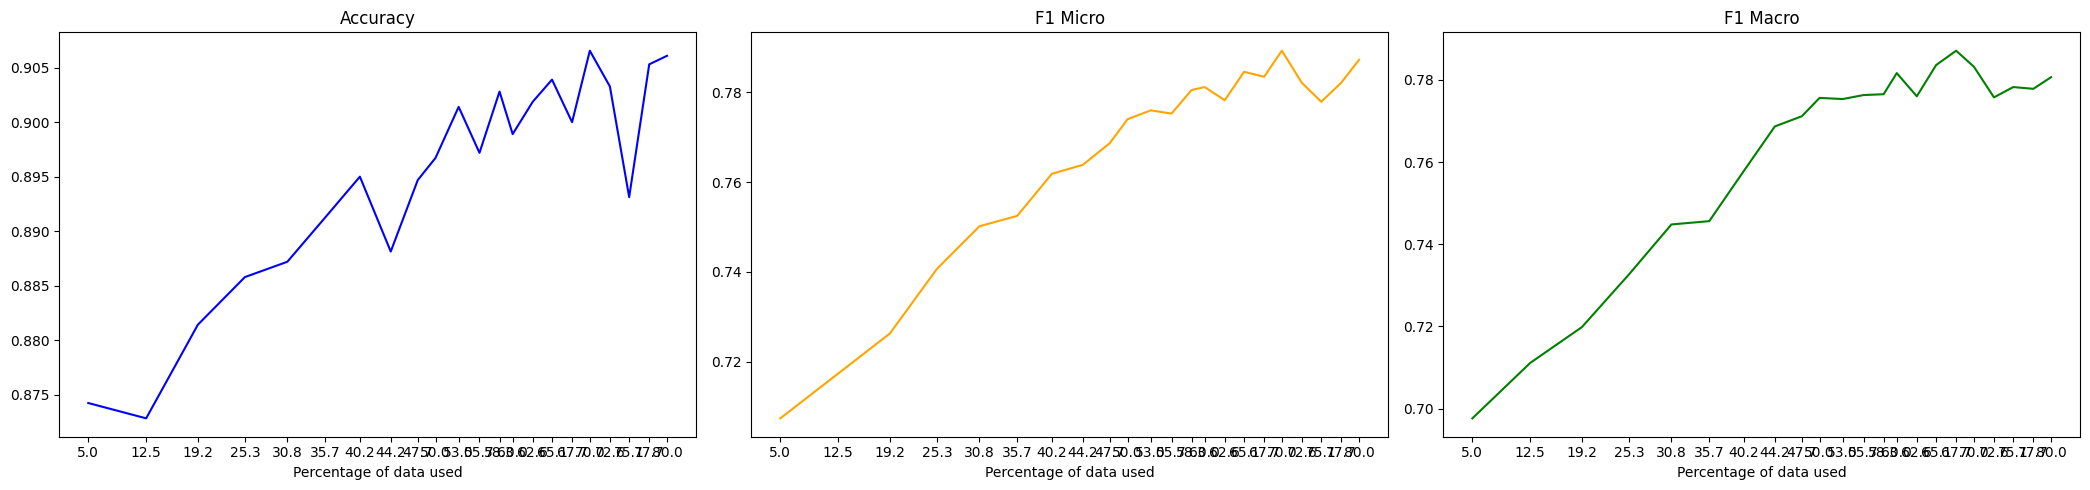

In [23]:
active_learning(seeds[4], 4)